In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [135]:
#vocabulary = read_data(filename)
#print('Data size', len(vocabulary))
f = open('only_paths.txt')
vocabulary = f.readlines()
vocabulary = [i.strip() for i in vocabulary]
# Step 2: Build the dictionary and replace rare words with UNK token.
#vocabulary_size = 100000

In [3]:
tokens = []
for i in range(len(vocabulary)):
    splits = vocabulary[i].split(' ')
    for j in range(len(splits)):
        tokens.append(splits[j])
unique_tokens = set(tokens)
vocabulary_size = len(unique_tokens)
len(unique_tokens)

24612

In [4]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    #count = [[]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    #print(count)
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        #print(word,index)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [5]:
len(tokens),len(vocabulary)

(925915, 246129)

In [6]:
# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(tokens,len(tokens))#vocabulary,vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)',count[-5:])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 0], ('6939', 107760), ('9002', 28904), ('6830', 21032), ('7545', 14248)]
Least common words (+UNK) [('62968', 1), ('49916', 1), ('23710', 1), ('15559', 1), ('262552', 1)]
Sample data [1, 21, 1810, 6093, 1, 21, 1810, 6093, 1, 21] ['6939', '4826', '38803', '56203', '6939', '4826', '38803', '56203', '6939', '4826']


In [7]:
len(vocabulary)

246129

In [8]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            #buffer[:] = data[:span]
            for word in data[:span]:
                buffer.append(word)
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [9]:
batch, labels = generate_batch(batch_size=16, num_skips=2, skip_window=1)
for i in range(16):
    print(batch[i], reverse_dictionary[batch[i]],
                '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

21 4826 -> 1 6939
21 4826 -> 1810 38803
1810 38803 -> 6093 56203
1810 38803 -> 21 4826
6093 56203 -> 1 6939
6093 56203 -> 1810 38803
1 6939 -> 6093 56203
1 6939 -> 21 4826
21 4826 -> 1 6939
21 4826 -> 1810 38803
1810 38803 -> 21 4826
1810 38803 -> 6093 56203
6093 56203 -> 1810 38803
6093 56203 -> 1 6939
1 6939 -> 21 4826
1 6939 -> 6093 56203


In [10]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 128  # Dimension of the embedding vector. 32. lets try higher dims
skip_window = 4       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

In [11]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [43]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/gpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.1
    learning_rate = tf.train.natural_exp_decay(starter_learning_rate, global_step,2500, 0.63, staircase=False)
    # Passing global_step to minimize() will increment it at each step.
    #learning_step = (tf.train.GradientDescentOptimizer(learning_rate).minimize(...my loss..., global_step=global_step))
    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    #optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # What if we use AdamOptimizer
    optimizer = (tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step = global_step))
    
    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),
     1, keepdims=True)) #keep_dims is deprecated use keepdims instead
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)
    lr_print = tf.Print(learning_rate,[learning_rate])
    # Add variable initializer.
    init = tf.global_variables_initializer()

In [44]:
# Step 5: Begin training.
num_steps = 25001

In [45]:
import time
start = time.time()
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val,__ = session.run([optimizer, loss,lr_print], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss,'learning rate: ',__)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        #if step % 10000 == 0: #500 == 0:#
        #	sim = similarity.eval()
        #	for i in xrange(valid_size):
        #		valid_word = reverse_dictionary[valid_examples[i]]
        #		top_k = 4#8  # number of nearest neighbors
        #		nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        #		log_str = 'Nearest to %s:' % valid_word
        #		for k in xrange(top_k):
        #			close_word = reverse_dictionary[nearest[k]]
        #			log_str = '%s %s,' % (log_str, close_word)
        #		print(log_str)
    final_embeddings = normalized_embeddings.eval()
end = time.time()
print("Time Taken: {}".format(end-start))

Initialized
Average loss at step  0 :  216.59146118164062 learning rate:  0.1
Average loss at step  1000 :  183.80479620742798 learning rate:  0.07772448
Average loss at step  2000 :  158.65861807513238 learning rate:  0.060410943
Average loss at step  3000 :  128.2463497815132 learning rate:  0.046954088
Average loss at step  4000 :  96.96140673065186 learning rate:  0.036494818
Average loss at step  5000 :  76.84534278440475 learning rate:  0.028365402
Average loss at step  6000 :  60.47421453356743 learning rate:  0.022046862
Average loss at step  7000 :  52.12795135521889 learning rate:  0.017135806
Average loss at step  8000 :  34.214306683778766 learning rate:  0.0133187175
Average loss at step  9000 :  31.905944965362547 learning rate:  0.010351903
Average loss at step  10000 :  33.260116083800796 learning rate:  0.008045961
Average loss at step  11000 :  23.981742898762228 learning rate:  0.0062536797
Average loss at step  12000 :  19.768877621799707 learning rate:  0.004860642

In [46]:
final_embeddings.shape

(24612, 128)

In [47]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(20,20))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                                 xy=(x, y),
                                 xytext=(5, 2),
                                 textcoords='offset points',
                                 ha='right',
                                 va='bottom')

    plt.show()
    #plt.savefig(filename)try:
    # pylint: disable=g-import-not-at-top


final_embeddings size (24612, 128)


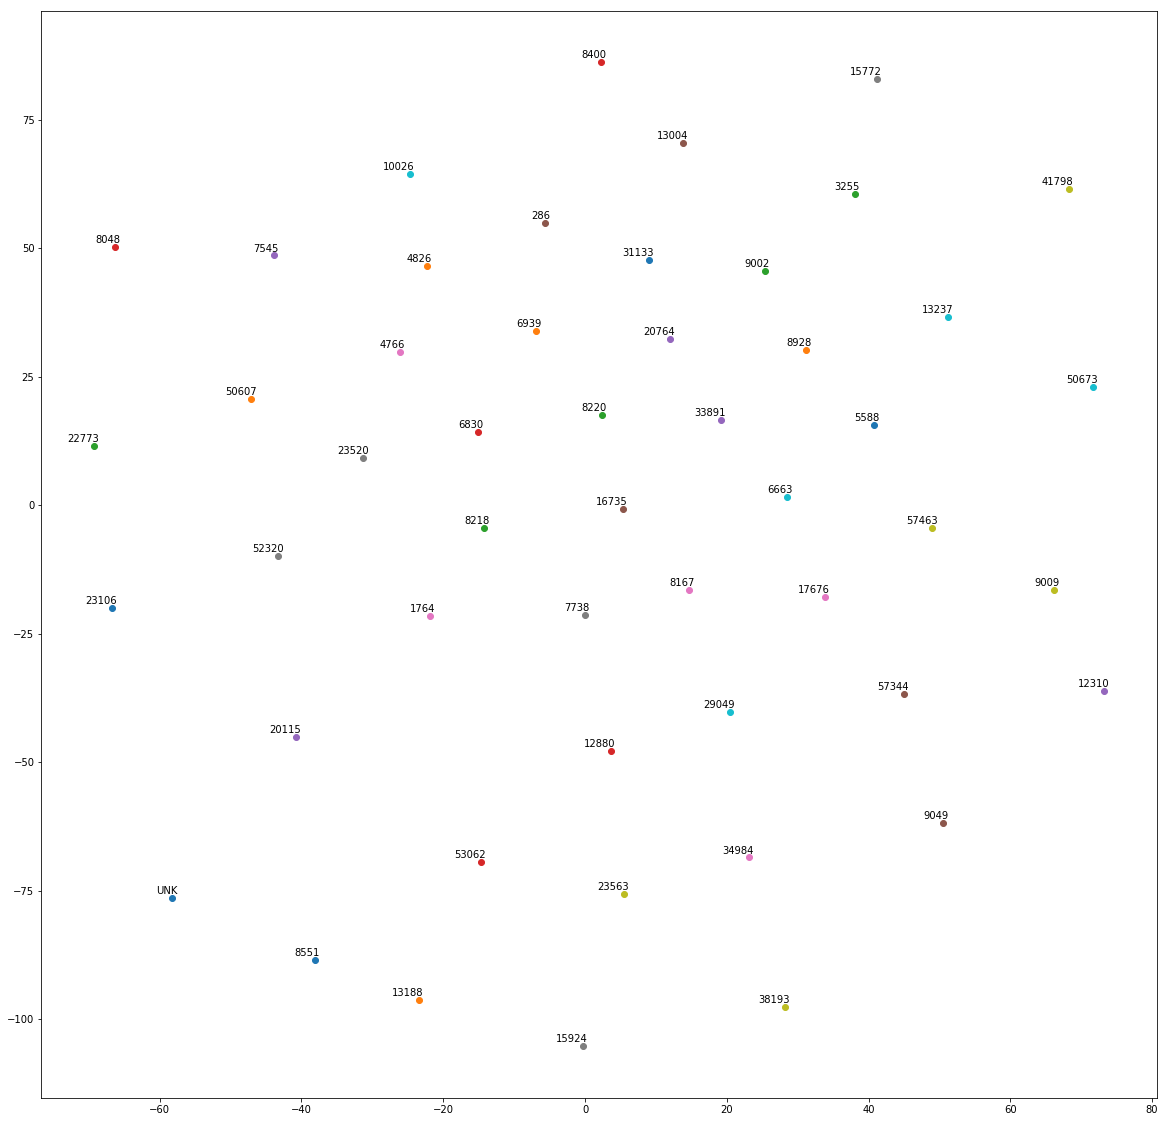

In [48]:
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline
    print("final_embeddings size",final_embeddings.shape)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 50
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), str("_"+str(num_steps)+".png")))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [57]:
final_embeddings[0].shape

(128,)

In [58]:
final_embeddings[dictionary['8551']]

array([ 0.02697013,  0.07171221,  0.08862047,  0.04657944,  0.15781397,
        0.04654428, -0.10133949, -0.11268003,  0.13293481, -0.07338777,
        0.03635913, -0.02910779,  0.03096073,  0.03404583, -0.10927113,
       -0.00074254, -0.07924861, -0.02790568, -0.04137498,  0.1886842 ,
       -0.14115225,  0.02015739,  0.1693138 , -0.01243462,  0.0636761 ,
        0.04007901, -0.1377249 ,  0.02684655,  0.18150191,  0.09880619,
        0.08792193, -0.11720697,  0.12413216, -0.04077939,  0.02411468,
        0.05086817, -0.12901837, -0.02134698,  0.1516013 , -0.09623143,
       -0.11497542,  0.01955473,  0.06056236,  0.01004932,  0.07076985,
       -0.09025636,  0.11986969,  0.05747686,  0.02505987,  0.2207363 ,
       -0.0205533 , -0.08485885, -0.05864777, -0.03445367,  0.01445611,
        0.05710248, -0.11332061, -0.21372412,  0.02442995, -0.01418591,
       -0.14099899, -0.00730709, -0.03843945,  0.11368905,  0.00460796,
       -0.1237213 , -0.12904488,  0.03751214, -0.03750096,  0.02

In [65]:
from functools import reduce
final_embeddings[dictionary['24724']]*final_embeddings[dictionary['50153']]@final_embeddings[dictionary['201793']]

0.001964876

In [153]:
s2v = vocabulary.copy()
for i in range(len(vocabulary)):
    splits = vocabulary[i].split(' ')
    splits2 = splits
    t= []
    for j in range(len(splits)):
        #print(type(j))
        splits2[j]= final_embeddings[dictionary[splits[j]]-1]
    s2v[i] = splits

In [154]:
len(s2v)

246129

In [156]:
type(s2v),len(s2v)

(list, 246129)

In [157]:
len(s2v[0])

4

In [172]:
dot_ps = []
for i in range(len(s2v)):
    t = s2v[i][0]
    for j in range(1,len(s2v[i])):
        t = np.dot(t,s2v[i][j])
    dot_ps.append(t)#np.linalg.multi_dot(t))

In [174]:
dot_ps[1230]

array([-0.02453607, -0.00799831, -0.06028452,  0.05601731,  0.09379228,
        0.02011571, -0.00527191, -0.01286072,  0.00063158,  0.02768514,
        0.03668053,  0.04386897,  0.03519263,  0.09022239, -0.02263038,
       -0.00596799, -0.03521589, -0.00295212,  0.01663888,  0.03191068,
       -0.02104064, -0.00648364,  0.04573116, -0.01157171,  0.02260975,
        0.01827063,  0.02871667,  0.05709418,  0.03109433, -0.02544893,
       -0.00191923, -0.01369349,  0.07508046, -0.02948481, -0.04438886,
        0.02611078, -0.00266394,  0.03449088, -0.0400134 ,  0.03663201,
        0.02576745, -0.00528802,  0.0225292 , -0.01757775, -0.00863098,
       -0.03789524,  0.03382809,  0.03143022,  0.07046959,  0.0806049 ,
        0.10344738, -0.04887927, -0.03799899, -0.03027533,  0.02122912,
        0.05780128, -0.00198185, -0.03433081,  0.05667878,  0.05523428,
       -0.04690744,  0.01090518,  0.03287309, -0.00508859,  0.0292271 ,
        0.07413746,  0.01009611,  0.04670562, -0.0908218 ,  0.02

In [168]:
len(dot_ps)

246129

In [169]:
len(vocabulary)

246129